# Fine-Tuning GPT-2 on Encrypted Data with LoRA and Concrete ML

In this notebook, we perform fine-tuning of a GPT-2 model using LoRA and Concrete ML.

In [1]:
# Import necessary libraries
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from utils_lora import generate_and_print, print_weights_and_size

from concrete.ml.torch.hybrid_model import HybridFHEModel
from concrete.ml.torch.lora import LoraTraining, get_remote_names

# Set random seed for reproducibility
SEED = 0
torch.manual_seed(SEED)

In [2]:
# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [3]:
generate_and_print(
    prompt="What is FHE?",
    model=model,
    tokenizer=tokenizer,
    seed=SEED,
)

What is FHE? FHE is a new type of energy storage that is designed to be used in a variety of applications. It is used to store energy in


In [4]:
# Apply LoRA to the model
# target_modules can be set to "all-linear"
# to target all modules. By default only the
# c_attn projection are fine-tuned with lora.
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model, peft_config)

In [5]:
# Set up LoRA training
lora_training = LoraTraining(peft_model)

LoRA layers detected in the model.


In [6]:
# Prepare dataset for fine-tuning
BLOCK_SIZE = 128

# Read lines from the file
with open("data_finetune/what_is_fhe.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Remove empty lines and strip whitespace
lines = [line.strip() for line in lines if line.strip()]

# Group lines into question-answer pairs
examples = []
for i in range(0, len(lines) - 1, 2):
    question = lines[i]
    answer = lines[i + 1]
    examples.append({"question": question, "answer": answer})

# Create a Dataset object from the list of examples
dataset = Dataset.from_list(examples)


# Tokenization function
def tokenize_function(examples):
    input_ids_list = []
    labels_list = []
    attention_masks_list = []
    for question, answer in zip(examples["question"], examples["answer"]):
        # Tokenize question and answer separately
        question_encoding = tokenizer(
            question, add_special_tokens=False, truncation=True, max_length=BLOCK_SIZE // 2
        )
        answer_encoding = tokenizer(
            answer, add_special_tokens=False, truncation=True, max_length=BLOCK_SIZE // 2 - 1
        )

        # Build input_ids
        input_ids = (
            question_encoding["input_ids"]
            + [tokenizer.eos_token_id]
            + answer_encoding["input_ids"]
            + [tokenizer.eos_token_id]
        )

        # Build labels: -100 for question tokens and eos token after question
        labels = (
            [-100] * len(question_encoding["input_ids"])
            + [-100]  # For the eos token after question
            + answer_encoding["input_ids"]
            + [tokenizer.eos_token_id]
        )

        # Create attention mask: 1 for real tokens, 0 for padding
        attention_mask = [1] * len(input_ids)

        # Pad/truncate to BLOCK_SIZE
        padding_length = BLOCK_SIZE - len(input_ids)
        if padding_length > 0:
            input_ids += [tokenizer.pad_token_id] * padding_length
            labels += [-100] * padding_length
            attention_mask += [0] * padding_length
        else:
            input_ids = input_ids[:BLOCK_SIZE]
            labels = labels[:BLOCK_SIZE]
            attention_mask = attention_mask[:BLOCK_SIZE]

        input_ids_list.append(input_ids)
        labels_list.append(labels)
        attention_masks_list.append(attention_mask)

    return {
        "input_ids": input_ids_list,
        "labels": labels_list,
        "attention_mask": attention_masks_list,
    }


# Apply the tokenization
tokenized_datasets = dataset.map(
    tokenize_function, batched=True, remove_columns=["question", "answer"]
)

# Since we've already handled padding and labels, we can use a custom data collator


def data_collator(features):
    batch = {}
    batch["input_ids"] = torch.tensor([f["input_ids"] for f in features], dtype=torch.long)
    batch["labels"] = torch.tensor([f["labels"] for f in features], dtype=torch.long)
    batch["attention_mask"] = torch.tensor(
        [f["attention_mask"] for f in features], dtype=torch.long
    )
    return batch

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

In [7]:
# Define training arguments
EPOCHS = 20
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=PER_DEVICE_TRAIN_BATCH_SIZE,
    gradient_accumulation_steps=1,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=2e-3,
    lr_scheduler_type="linear",
    seed=SEED,
    data_seed=SEED,
    warmup_steps=10,
    weight_decay=0.01,
    prediction_loss_only=True,
)


def causal_lm_loss(logits, labels, ignore_index=-100):
    # Shift logits and labels for next-token prediction
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tensors
    shift_logits = shift_logits.view(-1, shift_logits.size(-1))
    shift_labels = shift_labels.view(-1)

    # Compute the loss, ignoring padding tokens
    loss = torch.nn.functional.cross_entropy(
        shift_logits, shift_labels, ignore_index=ignore_index, reduction="mean"
    )

    return loss

In [8]:
# Initialize Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_datasets,
    data_collator=data_collator,
)

# Prepare for training
train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lr_scheduler = trainer.lr_scheduler
optimizer = trainer.optimizer

In [9]:
# Get the names of the remote modules (layers to be converted to FHE)
remote_names = get_remote_names(lora_training, include_embedding_layers=False)

In [10]:
# Create the HybridFHEModel with the specified remote modules
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [11]:
# Prepare input data for calibration
input_tensor = torch.randint(
    0, tokenizer.vocab_size, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE), dtype=torch.long
)
label_tensor = torch.randint(
    0, tokenizer.vocab_size, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE), dtype=torch.long
)
attention_mask = torch.ones((PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE), dtype=torch.long)

inputset = (input_tensor, label_tensor, attention_mask)

In [12]:
# Calibrate and compile the model
lora_training.toggle_calibrate(enable=True)
hybrid_model.compile_model(inputset, n_bits=16)
lora_training.toggle_calibrate(enable=False)

100%|██████████| 95/95 [00:11<00:00,  8.38it/s]


In [13]:
def train_custom_model(
    hybrid_model, train_dataloader, training_args, tokenizer, fhe="disable"
):  # pylint: disable=too-many-locals
    device = "cuda"
    hybrid_model.model.to(device)

    # Training loop
    peft_model.train()
    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []

    # Generate text before the first epoch
    print("Generating text before the first epoch:\n")
    prompt = "What is FHE?"
    hybrid_model.set_fhe_mode("disable")
    generate_and_print(prompt, peft_model, tokenizer, SEED)
    hybrid_model.set_fhe_mode(fhe)

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        for _, batch in enumerate(train_dataloader):
            total_batched_samples += 1
            batch = {k: v.to(device) for k, v in batch.items()}

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            loss, grad_norm = hybrid_model(
                (batch["input_ids"], batch["labels"], batch["attention_mask"]), fhe=fhe
            )

            # Optimizer step
            optimizer.step()

            # Learning rate scheduler step
            lr_scheduler.step()

            total_loss += loss.item()
            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1] if grad_norms else None

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        # Generate text after each epoch
        prompt = "What is FHE?"
        hybrid_model.set_fhe_mode("disable")
        generate_and_print(prompt, peft_model, tokenizer, SEED)
        hybrid_model.set_fhe_mode(fhe)

        print("\n" + "-" * 50)  # Separator for readability
        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        peft_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Generating text before the first epoch:

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean
Epoch 1/20, Loss: 93.5096, grad norm: None, lr: 0.002


Training Progress:   5%|▌         | 1/20 [00:13<04:25, 13.99s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 2/20, Loss: 94.1080, grad norm: None, lr: 0.002


Training Progress:  10%|█         | 2/20 [00:16<02:14,  7.49s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 3/20, Loss: 92.3297, grad norm: None, lr: 0.002


Training Progress:  15%|█▌        | 3/20 [00:19<01:32,  5.43s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 4/20, Loss: 94.3702, grad norm: None, lr: 0.002


Training Progress:  20%|██        | 4/20 [00:22<01:11,  4.44s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 5/20, Loss: 94.3633, grad norm: None, lr: 0.002


Training Progress:  25%|██▌       | 5/20 [00:25<00:58,  3.89s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 6/20, Loss: 94.2495, grad norm: None, lr: 0.002


Training Progress:  30%|███       | 6/20 [00:28<00:49,  3.56s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 7/20, Loss: 93.2459, grad norm: None, lr: 0.002


Training Progress:  35%|███▌      | 7/20 [00:31<00:43,  3.34s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 8/20, Loss: 94.8920, grad norm: None, lr: 0.002


Training Progress:  40%|████      | 8/20 [00:34<00:38,  3.23s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 9/20, Loss: 92.5591, grad norm: None, lr: 0.002


Training Progress:  45%|████▌     | 9/20 [00:37<00:34,  3.13s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 10/20, Loss: 94.3383, grad norm: None, lr: 0.002


Training Progress:  50%|█████     | 10/20 [00:40<00:30,  3.07s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 11/20, Loss: 93.8408, grad norm: None, lr: 0.002


Training Progress:  55%|█████▌    | 11/20 [00:43<00:27,  3.04s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 12/20, Loss: 93.9941, grad norm: None, lr: 0.002


Training Progress:  60%|██████    | 12/20 [00:46<00:24,  3.01s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 13/20, Loss: 93.4639, grad norm: None, lr: 0.002


Training Progress:  65%|██████▌   | 13/20 [00:49<00:20,  2.99s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 14/20, Loss: 93.3730, grad norm: None, lr: 0.002


Training Progress:  70%|███████   | 14/20 [00:52<00:17,  2.98s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 15/20, Loss: 94.9715, grad norm: None, lr: 0.002


Training Progress:  75%|███████▌  | 15/20 [00:55<00:14,  2.95s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 16/20, Loss: 94.3447, grad norm: None, lr: 0.002


Training Progress:  80%|████████  | 16/20 [00:58<00:11,  2.94s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 17/20, Loss: 93.9694, grad norm: None, lr: 0.002


Training Progress:  85%|████████▌ | 17/20 [01:00<00:08,  2.90s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 18/20, Loss: 94.0268, grad norm: None, lr: 0.002


Training Progress:  90%|█████████ | 18/20 [01:03<00:05,  2.88s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 19/20, Loss: 91.6927, grad norm: None, lr: 0.002


Training Progress:  95%|█████████▌| 19/20 [01:06<00:02,  2.87s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------
Epoch 20/20, Loss: 92.0436, grad norm: None, lr: 0.002


Training Progress: 100%|██████████| 20/20 [01:09<00:00,  2.86s/it]

What is FHE? FHE is a term used to describe the process of a person's life. It is used in the term "fhe" to mean

--------------------------------------------------


Training Progress: 100%|██████████| 20/20 [01:09<00:00,  3.49s/it]


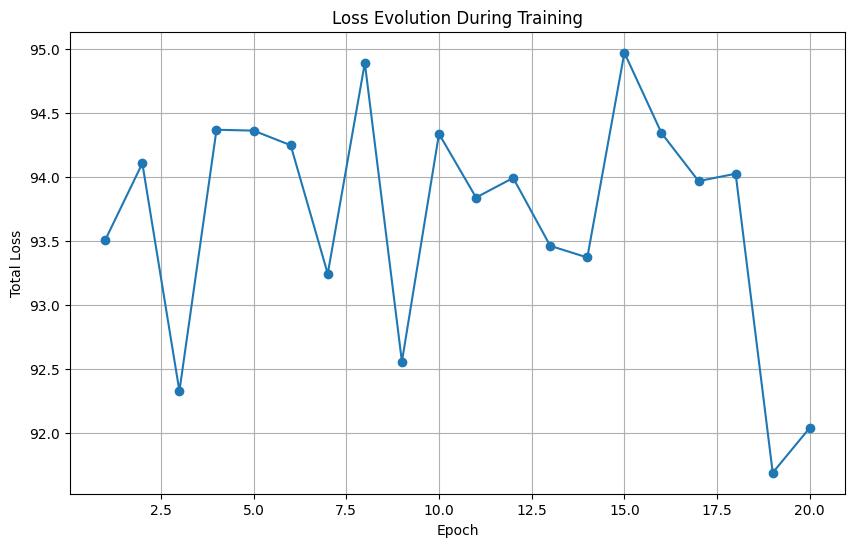

In [14]:
# Avoid parallelism error from HuggingFace during training
tokenizer.parallelism = False

# Train the model using FHE simulation
train_custom_model(hybrid_model, train_dataloader, training_args, tokenizer, fhe="disable")

Note that our goal is to showcase the use of FHE for encrypted fine-tuning. The dataset consists of 68 examples and a total of 2,386 tokens, which is relatively small. Despite its limited size, which offers little support for the model's learning process, it still manages to produce interesting results.

In [16]:
# Get the fine-tuned model
fine_tuned_model = hybrid_model.model.inference_model

# Set FHE mode to disable for text generation
hybrid_model.set_fhe_mode("disable")

In [18]:
# Inference using the fine-tuned model with LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

fine_tuned_model.enable_adapter_layers()
prompt = "who invented FHE?"
generate_and_print(prompt, fine_tuned_model, tokenizer, SEED)

who invented FHE?
FHE was first proposed by Craig Gentry in 2009, making it easier to use plaintexts on encrypted data. His breakthrough demonstrated ability to


In [17]:
# Original inference without LoRA weights
# Seed for reproducibility
torch.manual_seed(SEED)

peft_model.disable_adapter_layers()

prompt = "What is FHE?"
generate_and_print(prompt, peft_model, tokenizer, SEED)

What is FHE?
FHE is a new type of energy storage that is designed to be used in a variety of applications. It is used to store energy in


In [18]:
peft_model.enable_adapter_layers()

# Print weights and model size
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124734720
Total number of LoRA weights: 294912


In [19]:
# Save the model
path = Path("deployment/gpt2_lora_finetuned")
path.mkdir(parents=True, exist_ok=True)

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [20]:
# Print weights and size after saving
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 39717120
Total number of LoRA weights: 294912


In [21]:
# Calculate and print the percentage of weights removed
percentage_removed = (total_weights_size - total_weights_size_private) / total_weights_size * 100
print(f"Total weights removed: {percentage_removed:.2f} %")

Total weights removed: 68.16 %


In [22]:
# Note: Around 95% of the remaining weights are from the embedding layers (wpe and wte)
# as well as the final lm_head layer.